<a href="https://colab.research.google.com/github/shobhittya/deeplearning/blob/main/ResNet18_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
CUDA_LAUNCH_BLOCKING = "1"

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from tqdm.notebook import tqdm

import time
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import math
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch
from tqdm.notebook import tqdm

In [ ]:
#Data Transformation and Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

**Downloading datasets**

In [ ]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')



  0%|          | 0/135107811 [00:00<?, ?it/s]

In [ ]:
# Extract from archive
import tarfile
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
data_dir = './data/cifar10'

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


**Dataloaders**

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])

image_dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=1) for x in ['train', 'test']}
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=1, shuffle=False, num_workers=1)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

using device: cuda:0


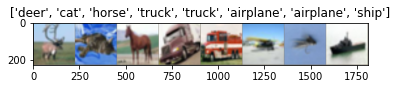

In [ ]:
def imshow(imgs, title=None):
    imgs = imgs.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(image_dataloader['train']))

imgs = torchvision.utils.make_grid(inputs)

imshow(imgs, title=[class_names[x] for x in classes])

In [ ]:
def train(model, criterion, optimizer, scheduler, num_epochs=30, early_stopping=True):
    last_loss = 100
    patience = 5
    trigger_times = 0
    
    total_start = time.time()
    
    total_train_accuracy = []
    total_train_loss = []
    total_val_accuracy = []
    total_val_loss = []

    best_model_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        start = time.time()
        print('Epoch {} / {}'.format(epoch, num_epochs-1))
        print('-' * 20)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            #for inputs, labels in tqdm(image_dataloader[phase]):
            for index, (inputs, labels) in enumerate(image_dataloader[phase]):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.float() / dataset_sizes[phase]
            
            if phase == 'train':
                total_train_loss.append(epoch_loss)
                total_train_accuracy.append(epoch_accuracy)
            if phase == 'val':
                total_val_loss.append(epoch_loss)
                total_val_accuracy.append(epoch_accuracy)

            print('{} Loss: {:.5f} Accuracy: {:.5f}'.format(phase, epoch_loss, epoch_accuracy))

            if phase == 'val' and epoch_accuracy > best_acc:
                best_acc = epoch_accuracy
                best_loss = epoch_loss
                best_model_weight = copy.deepcopy(model.state_dict())
            
            if early_stopping and phase == 'test':
                if last_loss < epoch_loss:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print('Early stopping at epoch {}'.format(epoch))
                        total_time_elapsed = np.round(time.time() - total_start, 3)
                        print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
                        print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))
                        model.load_state_dict(best_model_weight)
                        return model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss
                else:
                    trigger_times = 0
                last_loss = epoch_loss
        
        #save on every 10 epochs
        if epoch % 10 == 0:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'epoch': epoch
            }, '/content/Weights/ResNet18_epoch_{}.pt'.format(epoch))

        end = np.round(time.time() - start, 3)
        print('Epoch {}: {}s\n'.format(epoch, end))

    total_time_elapsed = np.round(time.time() - total_start, 3)
    print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
    print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))

    model.load_state_dict(best_model_weight)
    return model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss

**Visualization for validation set**

In [ ]:
def visualize_model(model, num_imgs=4):
    train_phase = model.training
    model.eval()
    total_images_processed = 0
    fig = plt.figure()

    with torch.no_grad():
        #for inputs, labels in tqdm(image_dataloader['val']):
        for index, (inputs, labels) in enumerate(image_dataloader['val']):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                total_images_processed += 1
                ax = plt.subplot(num_imgs//2, 2, total_images_processed)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if total_images_processed == num_imgs:
                    model.train(mode=train_phase)
                    return
        model.train(mode=train_phase)

**Network Architecture**

In [ ]:
#Load pretrained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.005, momentum=0.9)
learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**Training the Model**

In [12]:
model, total_train_accuracy, total_train_loss, total_val_accuracy, total_val_loss = train(model, criterion, optimizer, \
                                                                                          learning_rate_scheduler, num_epochs=100, early_stopping=True)

Epoch 0 / 99
--------------------
train Loss: 1.39582 Accuracy: 0.64250
test Loss: 1.23567 Accuracy: 0.73120
Epoch 0: 172.691s

Epoch 1 / 99
--------------------
train Loss: 1.39063 Accuracy: 0.66568
test Loss: 1.02664 Accuracy: 0.73840
Epoch 1: 168.974s

Epoch 2 / 99
--------------------
train Loss: 1.36982 Accuracy: 0.67188
test Loss: 1.04046 Accuracy: 0.75200
Epoch 2: 167.246s

Epoch 3 / 99
--------------------
train Loss: 1.33905 Accuracy: 0.67696
test Loss: 1.13634 Accuracy: 0.72120
Epoch 3: 167.027s

Epoch 4 / 99
--------------------
train Loss: 1.36843 Accuracy: 0.67598
test Loss: 0.92547 Accuracy: 0.76550
Epoch 4: 168.246s

Epoch 5 / 99
--------------------
train Loss: 1.38251 Accuracy: 0.67682
test Loss: 1.31875 Accuracy: 0.72750
Epoch 5: 167.653s

Epoch 6 / 99
--------------------
train Loss: 1.35450 Accuracy: 0.68198
test Loss: 0.93002 Accuracy: 0.76480
Epoch 6: 167.21s

Epoch 7 / 99
--------------------
train Loss: 1.36771 Accuracy: 0.68254
test Loss: 1.02262 Accuracy: 0.75

**Accuracy and Loss Graph** 

<Figure size 432x288 with 0 Axes>

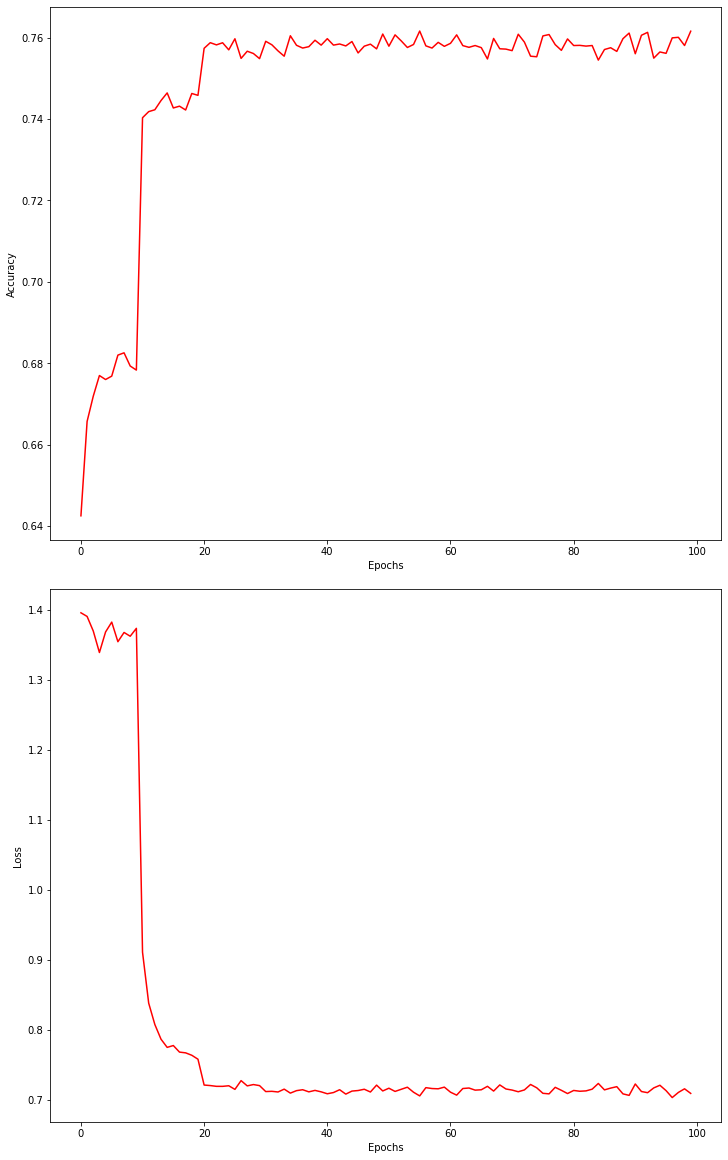

In [15]:
plt.clf()
fig, axs = plt.subplots(2, 1, figsize=(10, 16), constrained_layout=True)

total_train_accuracy = torch.Tensor(total_train_accuracy)
total_val_accuracy = torch.Tensor(total_val_accuracy)
total_train_loss = torch.Tensor(total_train_loss)
total_val_loss = torch.Tensor(total_val_loss)

axs[0].plot(total_train_accuracy, 'r-', label='train accuracy')
axs[0].plot(total_val_accuracy, 'b-', label='val accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

axs[1].plot(total_train_loss, 'r-', label='train loss')
axs[1].plot(total_val_loss, 'b-', label='val loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')

plt.show()

In [16]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion
}, '/content/ResNet18_final.pt')